# Loading ERA-20C data

The following example demonstrates how to load ERA-20C data provided by ECMWF in NetCDF3 format. We downloaded and renamed 10 files, each containing one year of monthly averaged Sea Surface Temperature (sst), Albedo (al), and Surface Pressure (sp) data and covering the years 2000 to 2010. 

First, we need to collect all file paths.

In [1]:
import os
import glob

ds_path = r"D:\data\code\yeoda\2022_08__docs\ecmwf_data"
filepaths = glob.glob(os.path.join(ds_path, "*.nc"))
filepaths

['D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2000_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2001_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2002_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2003_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2004_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2005_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2006_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2007_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2008_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2009_0.nc',
 'D:\\data\\code\\yeoda\\2022_08__docs\\ecmwf_data\\ERA-20C_2010_0.nc']

To properly ingest those files in a `DataCubeReader` object we need to define the settings for this new file naming convention. Everything should be interpreted as a string, except the year, which should be represented by a `datetime.date()` instance. Thus, we need to specify a decoding and encoding function before. We did this in a separate file/module `helpers`, since Python's *multiprocessing* library does not work with a Jupyter Notebook in this context.

```python
def str2date(s):
    return datetime.datetime.strptime(s, '%Y').date()

def date2str(t):
    return t.strftime('%Y') if isinstance(t, datetime.date) else t
```

In [2]:
from helpers import str2date, date2str

These functions can now be embedded into the definition of the different filename fields.

In [3]:
fields_def = dict([
        ('prod_name', {'len': 0}),
        ('year', {'len': 0,
                  'decoder': str2date,
                  'encoder': date2str}),
        ('tile_id', {'len': 0}),
    ])

fn_kwargs={'delimiter': "_", 'pad': "-"}

The next essential pre-setting is the mosaic and spatial reference, which should be used. Unfortunately, the NetCDF3 files lack in CRS information and can't be properly interpreted by *rioxarray*, thus tiles or a mosaic can't be generated automatically. The good thing is that the spatial context is quite straighforward, therefore we can pre-define our mosaic by hand:

In [4]:
from geospade.crs import SpatialRef
from geospade.raster import MosaicGeometry, Tile

geotrans = (0, 1, 0, 90, 0, -1)
global_tile = Tile(181, 360, SpatialRef(4326), geotrans=geotrans, name='0')
mosaic = MosaicGeometry.from_tile_list([global_tile])

C:\Users\cnavacch\AppData\Local\Continuum\miniconda3\envs\yeoda\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\cnavacch\AppData\Local\Continuum\miniconda3\envs\yeoda\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\cnavacch\AppData\Local\Continuum\miniconda3\envs\yeoda\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Finally, it is important to note, that the default NetCDF4 library used in the background fails in opening a NetCDF3 file. Thus, we need to explicitly state that we want to use the more flexible `NetCdfXrFile` class instead of the `NetCdf4File`. Additionally, the spatial dimensions ("latitude", "longitude") also differ from the default settings ("y", "x") and need to be passed as a keyword argument to `NetCdfXrFile`.

In [5]:
from veranda.raster.native.netcdf import NetCdfXrFile
file_class_kwargs={'space_dims': ["latitude", "longitude"]}

Now we have already everything prepared to read the data and can initialise our datacube! 

In [6]:
from yeoda.datacube import DataCubeReader

dc_reader = DataCubeReader.from_filepaths(filepaths,
                                          fields_def=fields_def, fn_kwargs=fn_kwargs,
                                          mosaic=mosaic, dimensions=["year", "tile_id"],
                                          stack_dimension="year",
                                          tile_dimension="tile_id",
                                          file_class=NetCdfXrFile,
                                          file_class_kwargs=file_class_kwargs)
dc_reader

DataCubeReader -> NetCdfReader(year, MosaicGeometry):

                                             filepath tile_id        year
0   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2000-01-01
1   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2001-01-01
2   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2002-01-01
3   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2003-01-01
4   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2004-01-01
5   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2005-01-01
6   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2006-01-01
7   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2007-01-01
8   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2008-01-01
9   D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2009-01-01
10  D:\data\code\yeoda\2022_08__docs\ecmwf_data\ER...       0  2010-01-01

*yeoda*'s datacubes also provide the possibility to define your own decoding or encoding functions to manipulate the data to suite your needs. Here, we can define a generic decoder function setting no data values to NaN, and applying a scale factor and offset value.

In [7]:
import numpy as np

def decoder(dar, nodataval=0, scale_factor=1, offset=0, data_variable=None, **kwargs):
    dar = dar.where(dar != nodataval, np.nan)
    dar = dar * scale_factor + offset
    return dar

Now we can read the whole dataset at once using our decoder and setting the `engine` option to "xarray" to be able to open the NetCDF3 formatted files.

In [8]:
dc_reader.read(engine="xarray", decoder=decoder)
dc_reader.data_view

<xarray.Dataset>
Dimensions:      (longitude: 360, latitude: 181, time: 132)
Coordinates:
  * longitude    (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude     (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time         (time) datetime64[ns] 2000-01-01 2000-02-01 ... 2010-12-01
    spatial_ref  int32 0
Data variables:
    sst          (time, latitude, longitude) float64 271.4 271.4 ... nan nan
    sp           (time, latitude, longitude) float64 1.013e+05 ... 6.744e+04
    al           (time, latitude, longitude) float64 0.07 0.07 ... 0.4773 0.4773

## Plotting albedo

Visualising the albedo of one specific month can directly be done using the *xarray* dataset.

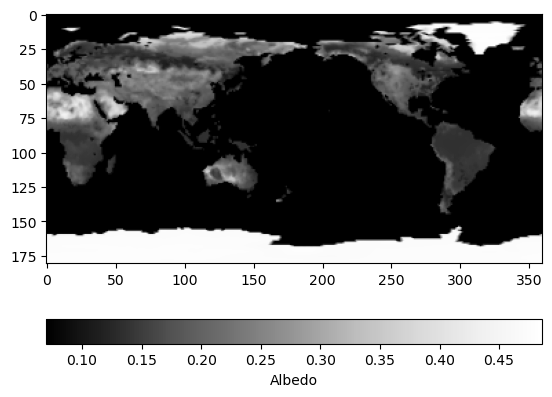

In [9]:
import matplotlib.pyplot as plt
import datetime

plt.imshow(dc_reader.data_view['al'].sel({'time': datetime.datetime(2000, 1, 1)}), cmap='Greys_r')
cbar = plt.colorbar(orientation='horizontal')
_ = cbar.ax.set_xlabel('Albedo')

## Sea surface temperature time-series analysis

Now lets do some time-series analysis and define three locations in different oceans.

In [10]:
poi_io = 75, -10  # Indian ocean
poi_ao = 350, 40  # Atlantic ocean
poi_po = 225, -30  # Pacific ocean

The coordinate tuples can then be forwarded to the datacube reader

In [11]:
dc_io = dc_reader.select_xy(*poi_io)
dc_ao = dc_reader.select_xy(*poi_ao)
dc_po = dc_reader.select_xy(*poi_po)

from which the time-series data can be directly retrieved.

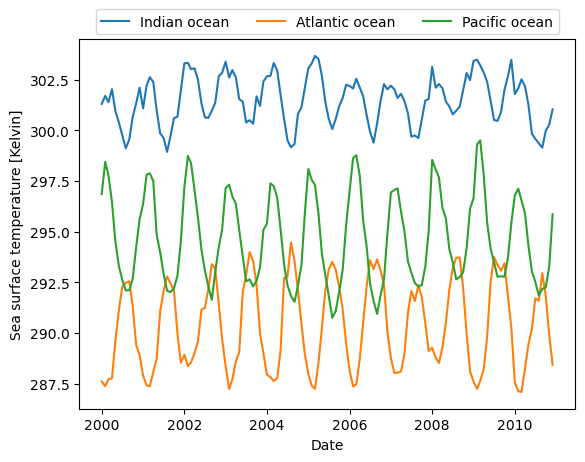

In [12]:
ts = dc_io.data_view['time']
plt.plot(ts, dc_io.data_view['sst'].data.flatten(), label='Indian ocean')
plt.plot(ts, dc_ao.data_view['sst'].data.flatten(), label='Atlantic ocean')
plt.plot(ts, dc_po.data_view['sst'].data.flatten(), label='Pacific ocean')
plt.xlabel('Date')
plt.ylabel('Sea surface temperature [Kelvin]')
_ = plt.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.1))